In [1]:
%matplotlib notebook

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime, timedelta
import time

import os

root = '../dataset'
t_path = ['dataset_1790789260.csv',
          'dataset_1095394822.csv',
          'dataset_479911147.csv',
          'dataset_665254893.csv',
          
        ] 

s_path = ['dataset_320725673.csv',
          'dataset_401881001.csv',
          'dataset_1992961554.csv',
          'dataset_852552682.csv',
         ] 

l_path = ['dataset_327382690.csv',
          'dataset_395223984.csv',
          'dataset_1999618571.csv',
         ]

# Outliers

An outlier is a data point that is very different from most of the remaining data.
Hawkins formally defined the notion of an outlier as follows
> An outlier is an observation which deviates so much from the other observations as to arouse suspicions that it was generated by a different mechanism.

One of the most common method used to found outliers is the Tukey Fence.
This method is based on the interquartile range (IQR):

if $Q_1$ and $Q_3$ are the lower and upper quartile, an outlier is any observation outside the range:

<center> $[ Q_1 - 1.5(Q_3 - Q_1), Q_3+1.5(Q_3-Q_1) ]$ </center>

In [2]:
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 9
fig_size[1] = 5
plt.rcParams["figure.figsize"] = fig_size

In [3]:
def time_shift(df):
    # add column to dataframe with the time distance from the previous measurement 
    
    ts = df.iloc[:,1]

    ts1 = ts[1:].values - ts[0:-1].values
    ts1 = np.concatenate([[0], ts1])
    ts1 = ts1/1000
    ts1 = ts1.round()
    
    ret = df.copy()
    ret[3] = ts1
    
    return ret

def count_outliers(df, index):
    '''
    :returtn: two dataframes
        one with the row corresponding to outliers
        one with the row corresponding to not outliers
    '''
    
    values = df.iloc[:, index].values
    Q = np.quantile(values, [.25, .75])
    Q1 = Q[0]
    Q3 = Q[1]
    IQR = Q3-Q1
    QL = Q1 - 1.5*IQR
    QH = Q3 + 1.5*IQR
    
    out_row = df[(df[index] < QL) | (df[index]>QH)]
    in_row = df[(df[index] >= QL) & (df[index] <= QH)]
    
    return in_row, out_row
    

## Values Outliers
Try to count the number of outliers on all data available

In [4]:
for path in t_path+s_path+l_path:
    path = os.path.join(root, path)
    df = pd.read_csv(path, header=None)
    
    st = df.iloc[0,0].split('/')[-1]
    room = df.iloc[0,0].split('/')[-2]
    
    non_out, out = count_outliers(df,2)
    
    print(room, st, len(out))
    


0x3bd temp 0
0xfef temp 0
0xd19 temp 389
0xd1a temp 0
0x3bd sound 4327
0xfef sound 480
0xd19 sound 503
0xd1a sound 498
0x3bd light 3622
0xfef light 647
0xd19 light 0


For some sensors there are no outliers count, for other there are maybe too much outliers

|Node|Type|%outliers|
|---|---|---|
|d19|temp|1.95|
|d19|sound|2.55|
|d19|light|0|
|fef|temp|0|
|fef|sound|2.4|
|fef|light|3.24|
|3bd|temp|0|
|3bd|sound|21.64|
|3bd|light|18.11|
|d1a|temp|0|
|d1a|sound|2.49|


<IPython.core.display.Javascript object>


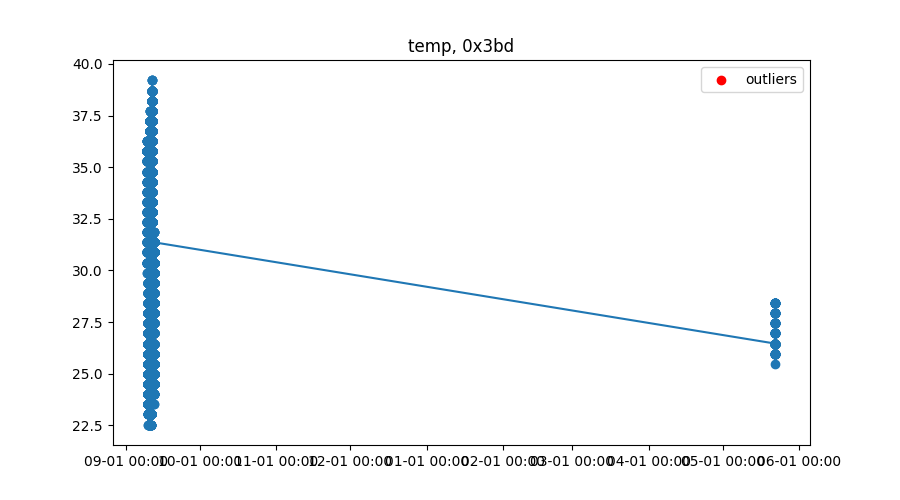

<IPython.core.display.Javascript object>


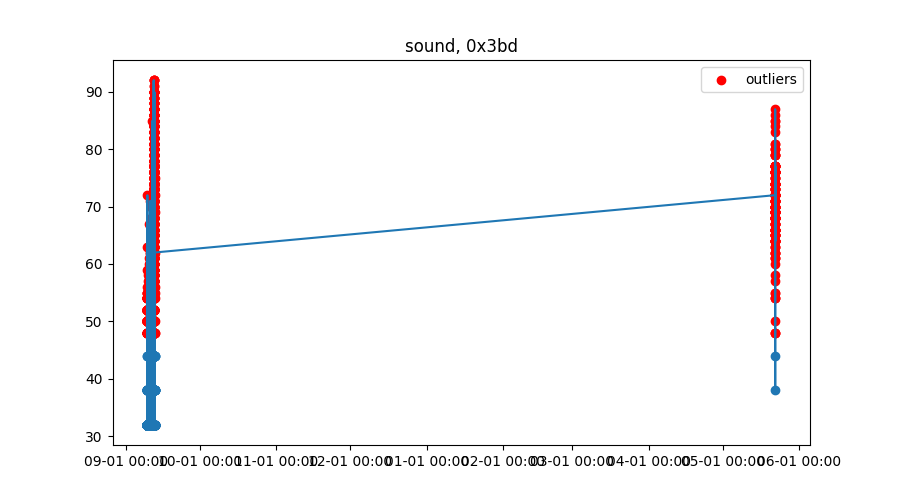

<IPython.core.display.Javascript object>


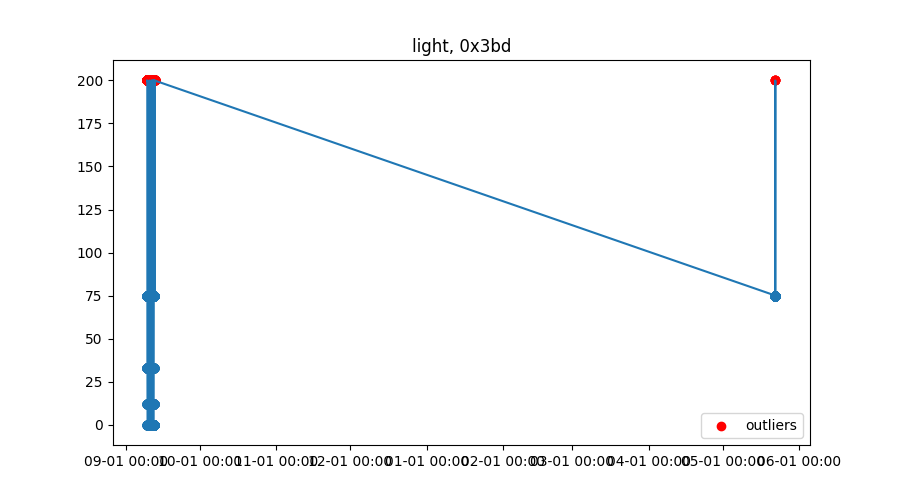

<IPython.core.display.Javascript object>


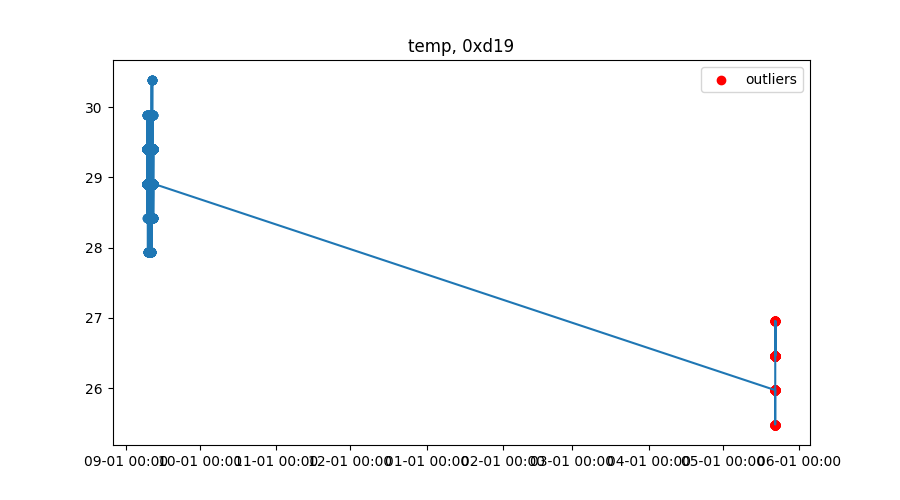

<IPython.core.display.Javascript object>


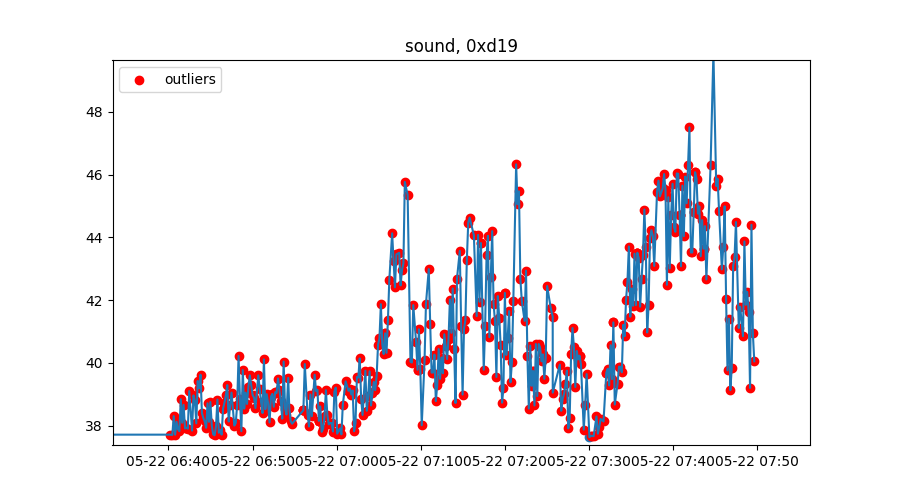

<IPython.core.display.Javascript object>


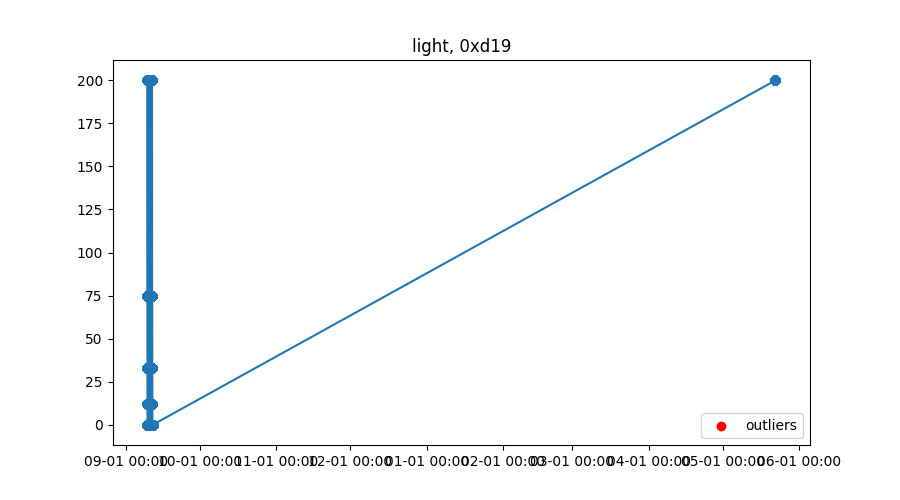

In [5]:
# add plot for some of the sensors
# room 3bd [0] and room d19 [2]

xfmt = mdates.DateFormatter('%m-%d %H:%M') #%b for month

to_plot = [t_path[0], s_path[0], l_path[0]]

for path in to_plot:
    path = os.path.join(root, path)
    df = pd.read_csv(path, header=None)
    
    non_out, out = count_outliers(df,2)
    
    st = df.iloc[0,0].split('/')[-1]
    room = df.iloc[0,0].split('/')[-2]
    
    fig, ax = plt.subplots()
    ax.xaxis.set_major_formatter(xfmt)
    ax.set_title(st + ", " + room)
    
    x = df.iloc[:,1].values.astype('datetime64[ms]')
    y = df.iloc[:,2].values
    plt.plot(x,y)
    
    x = non_out.iloc[:,1].values.astype('datetime64[ms]')
    y = non_out.iloc[:,2].values
    plt.scatter(x,y)
    
    x = out.iloc[:,1].values.astype('datetime64[ms]')
    y = out.iloc[:,2].values
    plt.scatter(x,y, c='r', label = 'outliers')
    
    plt.legend()
    plt.show()

to_plot = [t_path[2], s_path[2], l_path[2]]

for path in to_plot:
    path = os.path.join(root, path)
    df = pd.read_csv(path, header=None)
    
    non_out, out = count_outliers(df,2)
    
    st = df.iloc[0,0].split('/')[-1]
    room = df.iloc[0,0].split('/')[-2]
    
    fig, ax = plt.subplots()
    ax.xaxis.set_major_formatter(xfmt)
    ax.set_title(st + ", " + room)
    
    x = df.iloc[:,1].values.astype('datetime64[ms]')
    y = df.iloc[:,2].values
    plt.plot(x,y)
    
    x = non_out.iloc[:,1].values.astype('datetime64[ms]')
    y = non_out.iloc[:,2].values
    plt.scatter(x,y)
    
    x = out.iloc[:,1].values.astype('datetime64[ms]')
    y = out.iloc[:,2].values
    plt.scatter(x,y, c='r', label = 'outliers')
    
    plt.legend()
    plt.show()

## Time sequence outliers

Considering how many measurements are outliers, in the sense that the time between two measurements is too high or to low wrt the distribution.

One problem is given by the granularity of the timestamps, it is in ms. A lot of more values will be considered outliers, also when close to 10s, so the values are rounded to the closest second

In [6]:
for path in t_path+s_path+l_path:
    path = os.path.join(root, path)
    df = pd.read_csv(path, header=None)
    df = time_shift(df)
    
    st = df.iloc[0,0].split('/')[-1]
    room = df.iloc[0,0].split('/')[-2]
    
    non_out, out = count_outliers(df,3)
    
    print(room, st, len(out))

0x3bd temp 3616
0xfef temp 1360
0xd19 temp 1475
0xd1a temp 1346
0x3bd sound 3615
0xfef sound 1358
0xd19 sound 1477
0xd1a sound 1345
0x3bd light 3613
0xfef light 1362
0xd19 light 1477


All outliers are the datapoints that are not within 10s

|Node|Type|%outliers|
|---|---|---|
|d19|temp|7.36|
|d19|sound|7.39|
|d19|light|7.39|
|fef|temp|6.8|
|fef|sound|6.79|
|fef|light|6.81|
|3bd|temp|18.08|
|3bd|sound|18.08|
|3bd|light|18.07|
|d1a|temp|6.73|
|d1a|sound|6.73|



<IPython.core.display.Javascript object>


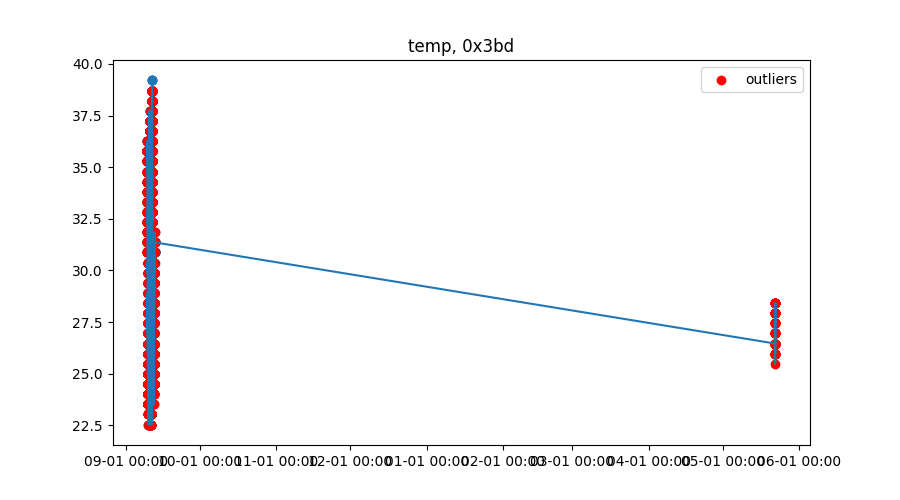

<IPython.core.display.Javascript object>


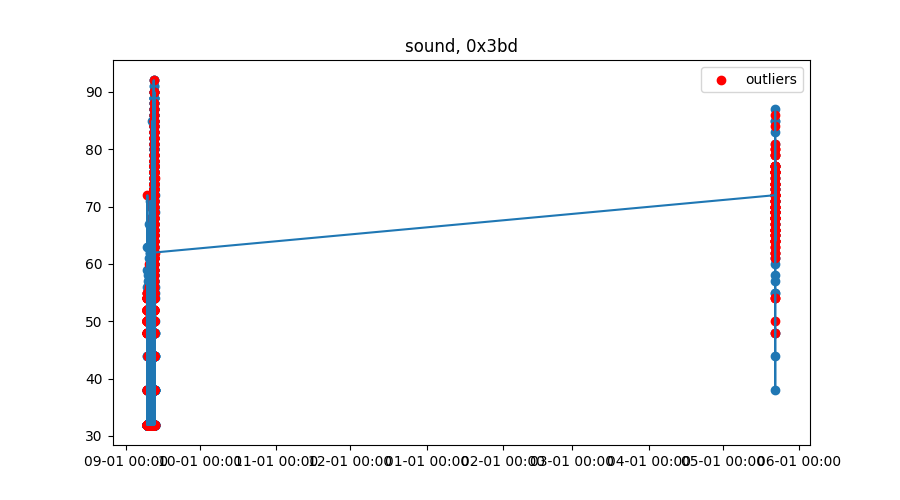

<IPython.core.display.Javascript object>


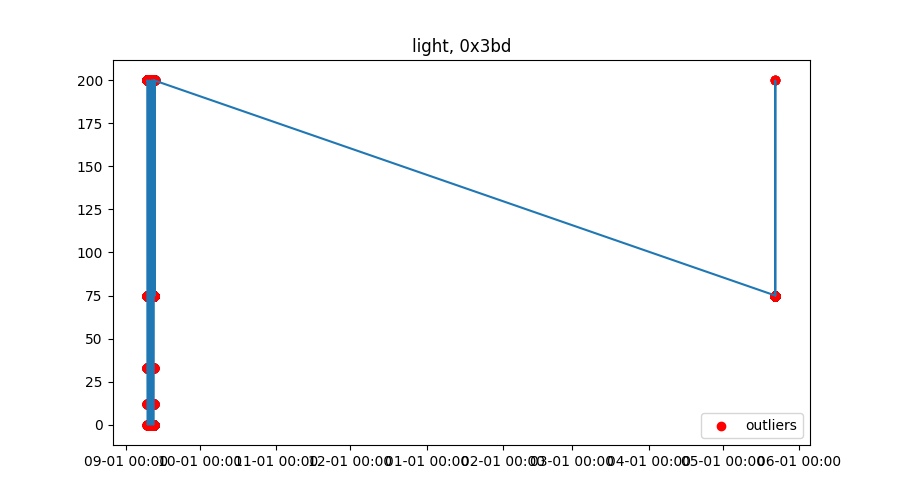

<IPython.core.display.Javascript object>


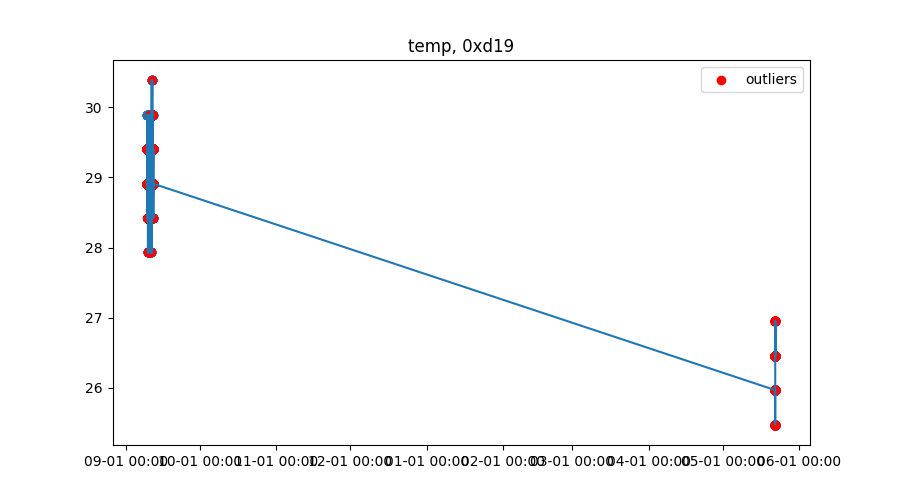

<IPython.core.display.Javascript object>


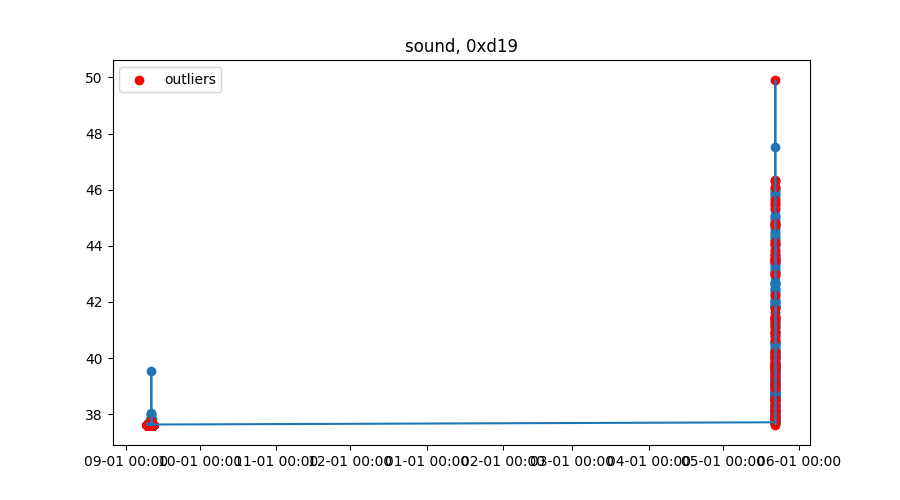

<IPython.core.display.Javascript object>


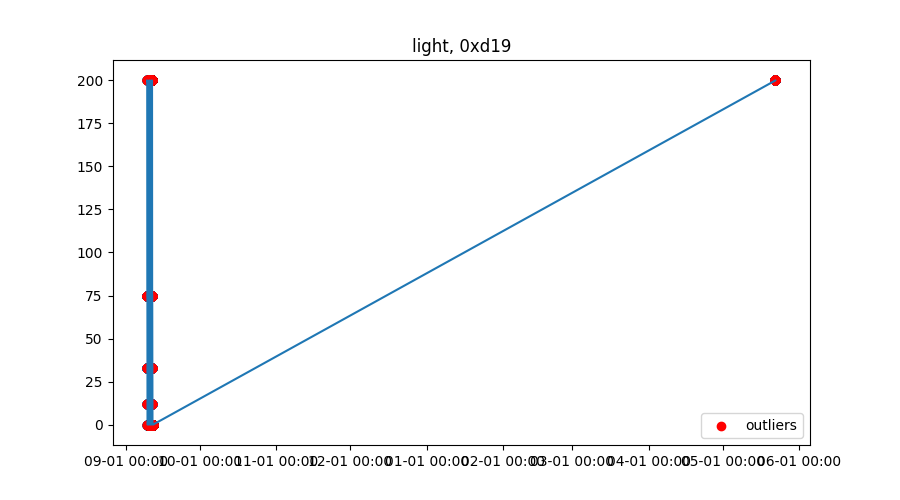

In [7]:
# add plot for some of the sensors
# room 3bd [0] and room d19 [2]

xfmt = mdates.DateFormatter('%m-%d %H:%M') #%b for month

to_plot = [t_path[0], s_path[0], l_path[0]]

for path in to_plot:
    path = os.path.join(root, path)
    df = pd.read_csv(path, header=None)
    df = time_shift(df)
    
    non_out, out = count_outliers(df,3)
    
    st = df.iloc[0,0].split('/')[-1]
    room = df.iloc[0,0].split('/')[-2]
    
    fig, ax = plt.subplots()
    ax.xaxis.set_major_formatter(xfmt)
    ax.set_title(st + ", " + room)
    
    x = df.iloc[:,1].values.astype('datetime64[ms]')
    y = df.iloc[:,2].values
    plt.plot(x,y)
    
    x = non_out.iloc[:,1].values.astype('datetime64[ms]')
    y = non_out.iloc[:,2].values
    plt.scatter(x,y)
    
    x = out.iloc[:,1].values.astype('datetime64[ms]')
    y = out.iloc[:,2].values
    plt.scatter(x,y, c='r', label = 'outliers')
    
    plt.legend()
    plt.show()

to_plot = [t_path[2], s_path[2], l_path[2]]

for path in to_plot:
    path = os.path.join(root, path)
    df = pd.read_csv(path, header=None)
    df = time_shift(df)
    
    non_out, out = count_outliers(df,3)
    
    st = df.iloc[0,0].split('/')[-1]
    room = df.iloc[0,0].split('/')[-2]
    
    fig, ax = plt.subplots()
    ax.xaxis.set_major_formatter(xfmt)
    ax.set_title(st + ", " + room)
    
    x = df.iloc[:,1].values.astype('datetime64[ms]')
    y = df.iloc[:,2].values
    plt.plot(x,y)
    
    x = non_out.iloc[:,1].values.astype('datetime64[ms]')
    y = non_out.iloc[:,2].values
    plt.scatter(x,y)
    
    x = out.iloc[:,1].values.astype('datetime64[ms]')
    y = out.iloc[:,2].values
    plt.scatter(x,y, c='r', label = 'outliers')
    
    plt.legend()
    plt.show()

In this case probably the points are not outliers, since the shape is the same, and the value assumed is always the same, furthermore it corresponds to hours where the building should be active (But the data is from a weekend) - Maybe in that hours the light is turned on anyway.

If we consider all the datapoints in the csv, the number of outliers changes.

## Count outliers in time window

Try to count the number of outliers using a sliding time window of x minutes (This can be adapted for flink)

In [8]:
def outliers_slider(df, mins=5, overlap = 0, index = 2):
    delta = np.timedelta64(mins,'m')
    step = delta - np.timedelta64(overlap, 'm')
        
    first_delta = df.iloc[0, 1]
    first_delta = first_delta.astype('datetime64[ms]').astype('datetime64[h]').astype('datetime64[ms]')
        
    window = []
        
    i = 0
        
    start = first_delta - step
    
    in_ret = pd.DataFrame()
    out_ret = pd.DataFrame()
    
    while i < len(df):
            
        window = []
        start = start + step
        end = start + delta
        end = end.astype('int64')
            
        while i < len(df) and df.iloc[i,1] < end:
            item = df.iloc[i,:]
            window.append(item)
            i += 1 
            
        if len(window) == 0:
            continue
                
        window_df = pd.DataFrame(window)
            
        in_window, out_window = count_outliers(window_df, index)
        
        in_ret = in_ret.append(in_window)
        out_ret = out_ret.append(out_window)
            
    return in_ret, out_ret
    
for path in t_path+s_path+l_path:
    path = os.path.join(root, path)
    df = pd.read_csv(path, header=None)
    df = time_shift(df)
    
    st = df.iloc[0,0].split('/')[-1]
    room = df.iloc[0,0].split('/')[-2]
    
    
    val_in, val_out = outliers_slider(df,2)
    ts_in, ts_out = outliers_slider(df, 3)
    
    print('a',room, st, len(val_in), len(val_out))
    print('b',room, st, len(ts_in), len(ts_out))

a 0x3bd temp 18078 1922
b 0x3bd temp 17928 2072
a 0xfef temp 19417 583
b 0xfef temp 19335 665
a 0xd19 temp 19085 915
b 0xd19 temp 19021 979
a 0xd1a temp 19157 843
b 0xd1a temp 19099 901
a 0x3bd sound 18176 1824
b 0x3bd sound 18052 1948
a 0xfef sound 19929 71
b 0xfef sound 19921 79
a 0xd19 sound 19946 54
b 0xd19 sound 19939 61
a 0xd1a sound 19842 158
b 0xd1a sound 19849 151
a 0x3bd light 19927 73
b 0x3bd light 19909 91
a 0xfef light 19908 92
b 0xfef light 19889 111
a 0xd19 light 19982 18
b 0xd19 light 19960 40


plot 3bd, d19

# Values

<IPython.core.display.Javascript object>


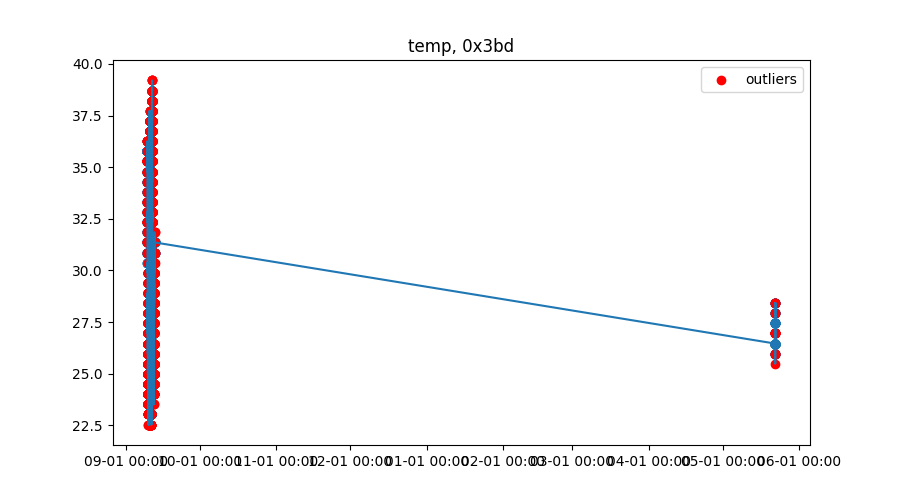

<IPython.core.display.Javascript object>


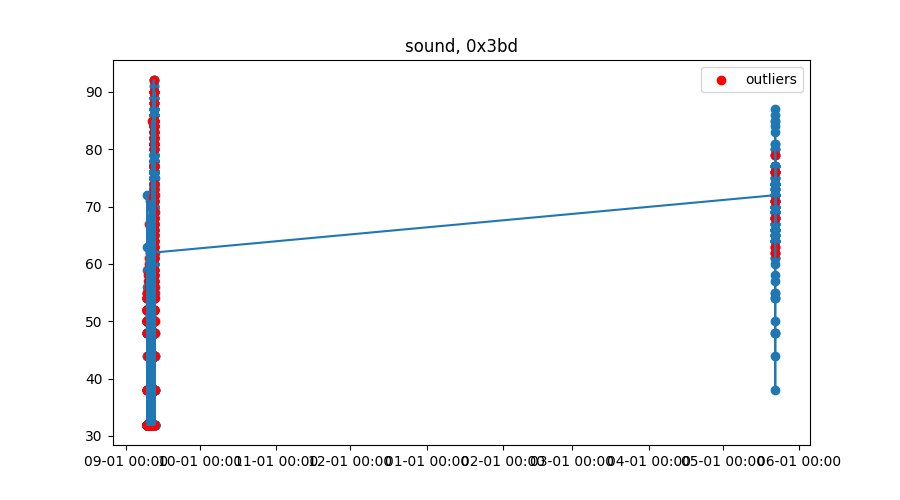

<IPython.core.display.Javascript object>


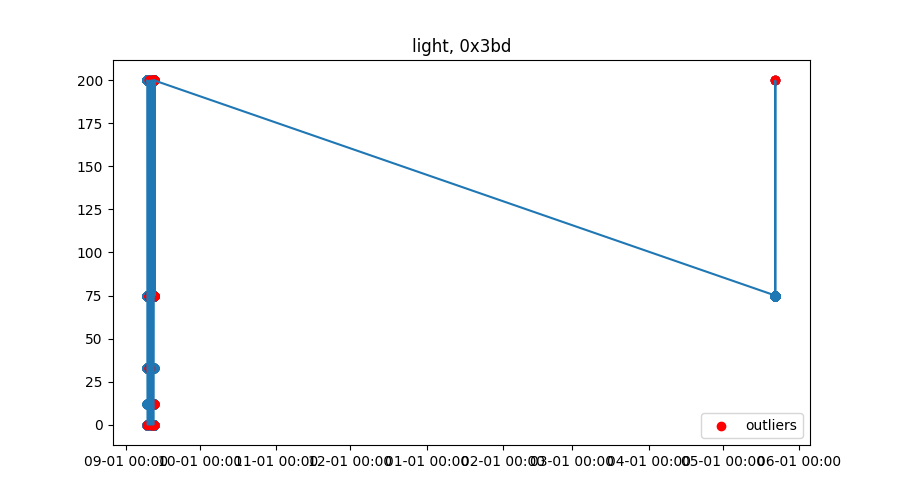

<IPython.core.display.Javascript object>


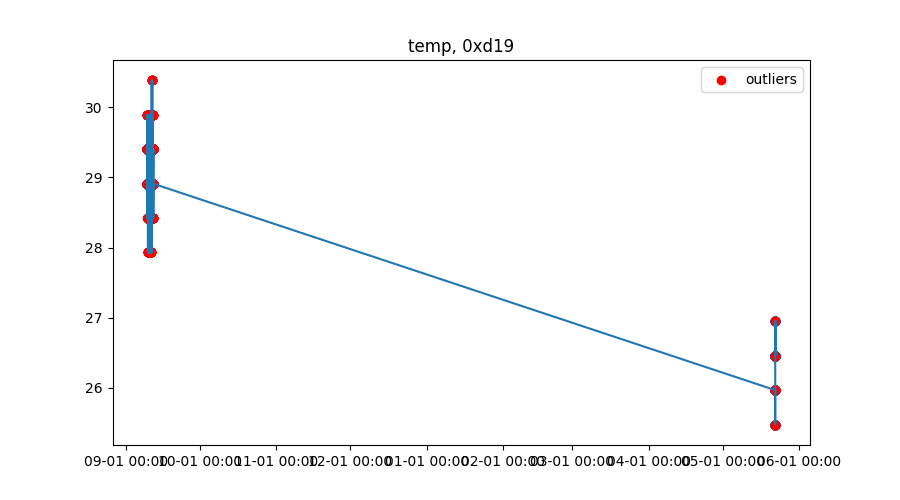

<IPython.core.display.Javascript object>


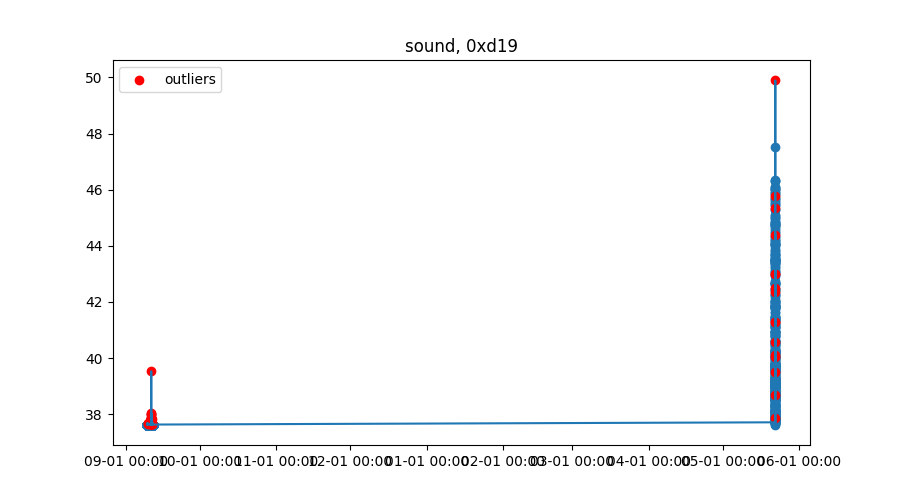

<IPython.core.display.Javascript object>


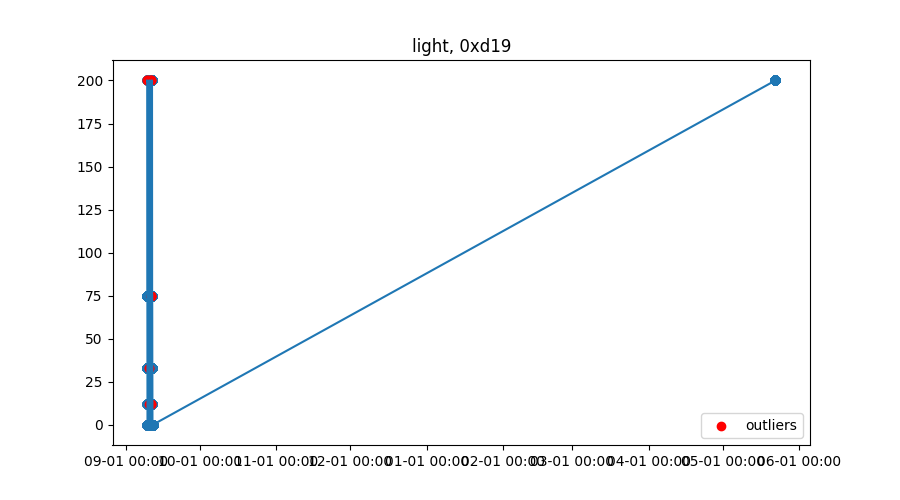

In [9]:
to_plot = [t_path[0], s_path[0], l_path[0]]

for path in to_plot:
    path = os.path.join(root, path)
    df = pd.read_csv(path, header=None)
    df = time_shift(df)
    
    non_out, out = outliers_slider(df,2)
    
    st = df.iloc[0,0].split('/')[-1]
    room = df.iloc[0,0].split('/')[-2]
    
    fig, ax = plt.subplots()
    ax.xaxis.set_major_formatter(xfmt)
    ax.set_title(st + ", " + room)
    
    x = df.iloc[:,1].values.astype('datetime64[ms]')
    y = df.iloc[:,2].values
    plt.plot(x,y)
    
    x = non_out.iloc[:,1].values.astype('datetime64[ms]')
    y = non_out.iloc[:,2].values
    plt.scatter(x,y)
    
    x = out.iloc[:,1].values.astype('datetime64[ms]')
    y = out.iloc[:,2].values
    plt.scatter(x,y, c='r', label = 'outliers')
    
    plt.legend()
    plt.show()

to_plot = [t_path[2], s_path[2], l_path[2]]

for path in to_plot:
    path = os.path.join(root, path)
    df = pd.read_csv(path, header=None)
    df = time_shift(df)
    
    non_out, out = outliers_slider(df,2)
    
    st = df.iloc[0,0].split('/')[-1]
    room = df.iloc[0,0].split('/')[-2]
    
    fig, ax = plt.subplots()
    ax.xaxis.set_major_formatter(xfmt)
    ax.set_title(st + ", " + room)
    
    x = df.iloc[:,1].values.astype('datetime64[ms]')
    y = df.iloc[:,2].values
    plt.plot(x,y)
    
    x = non_out.iloc[:,1].values.astype('datetime64[ms]')
    y = non_out.iloc[:,2].values
    plt.scatter(x,y)
    
    x = out.iloc[:,1].values.astype('datetime64[ms]')
    y = out.iloc[:,2].values
    plt.scatter(x,y, c='r', label = 'outliers')
    
    plt.legend()
    plt.show()

# Time sequence

<IPython.core.display.Javascript object>


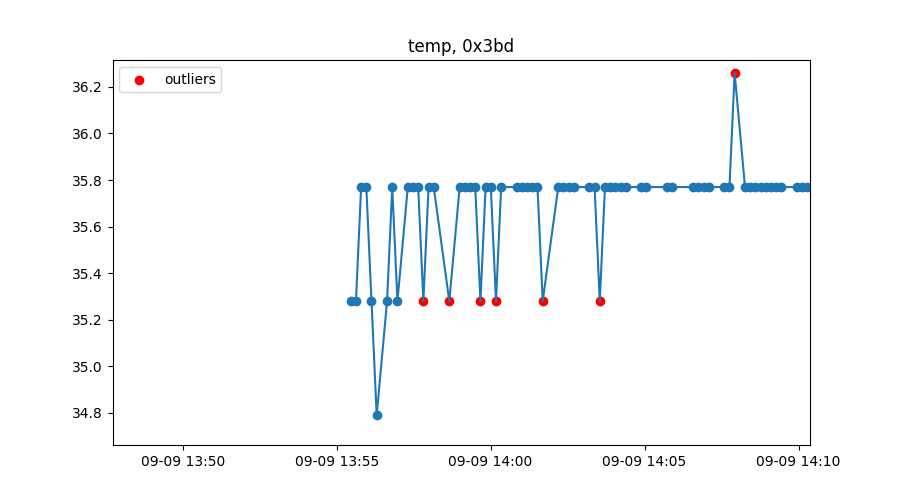

<IPython.core.display.Javascript object>


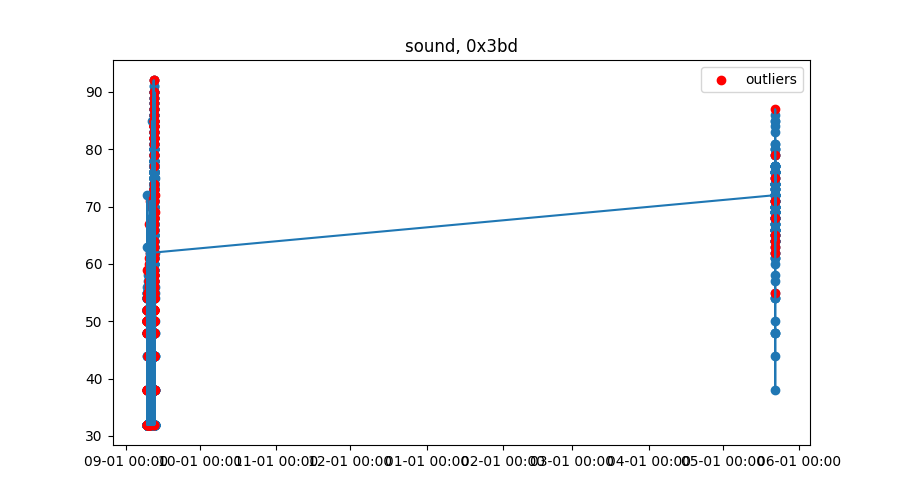

<IPython.core.display.Javascript object>


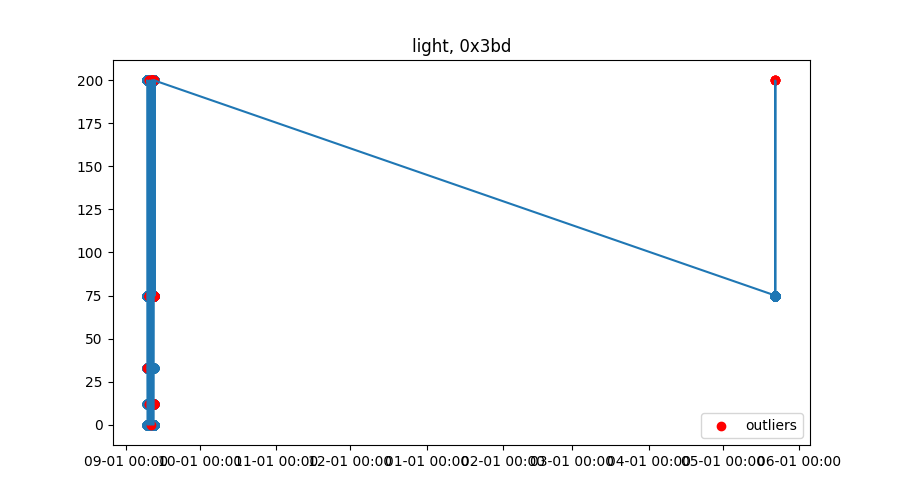

<IPython.core.display.Javascript object>


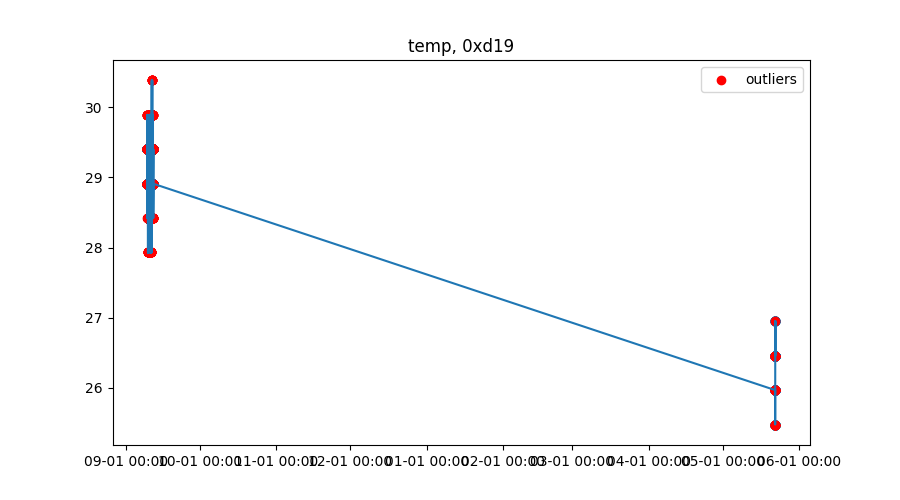

<IPython.core.display.Javascript object>


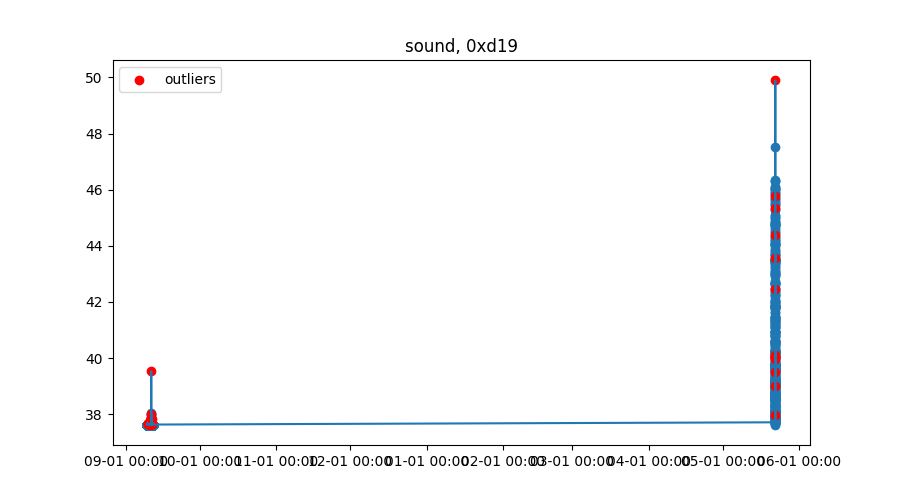

<IPython.core.display.Javascript object>


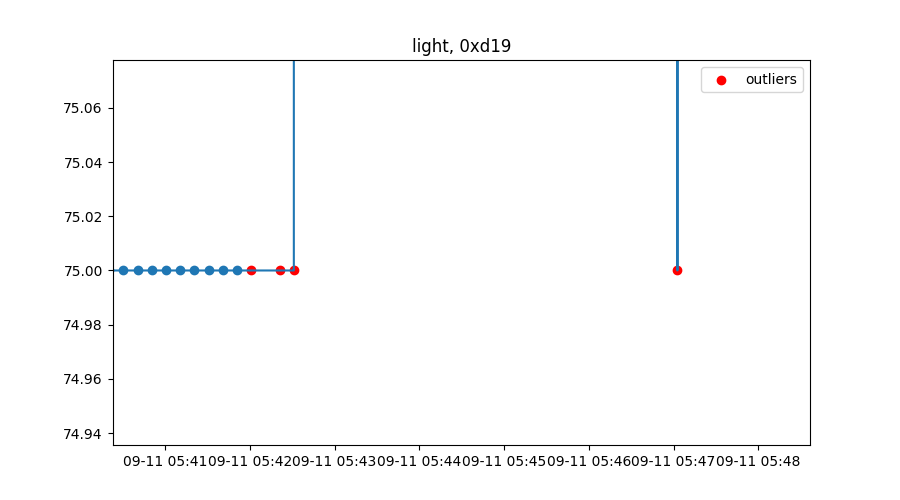

In [10]:
to_plot = [t_path[0], s_path[0], l_path[0]]

for path in to_plot:
    path = os.path.join(root, path)
    df = pd.read_csv(path, header=None)
    df = time_shift(df)
    
    non_out, out = outliers_slider(df,3)
    
    st = df.iloc[0,0].split('/')[-1]
    room = df.iloc[0,0].split('/')[-2]
    
    fig, ax = plt.subplots()
    ax.xaxis.set_major_formatter(xfmt)
    ax.set_title(st + ", " + room)
    
    x = df.iloc[:,1].values.astype('datetime64[ms]')
    y = df.iloc[:,2].values
    plt.plot(x,y)
    
    x = non_out.iloc[:,1].values.astype('datetime64[ms]')
    y = non_out.iloc[:,2].values
    plt.scatter(x,y)
    
    x = out.iloc[:,1].values.astype('datetime64[ms]')
    y = out.iloc[:,2].values
    plt.scatter(x,y, c='r', label = 'outliers')
    
    plt.legend()
    plt.show()

to_plot = [t_path[2], s_path[2], l_path[2]]

for path in to_plot:
    path = os.path.join(root, path)
    df = pd.read_csv(path, header=None)
    df = time_shift(df)
    
    non_out, out = outliers_slider(df,3)
    
    st = df.iloc[0,0].split('/')[-1]
    room = df.iloc[0,0].split('/')[-2]
    
    fig, ax = plt.subplots()
    ax.xaxis.set_major_formatter(xfmt)
    ax.set_title(st + ", " + room)
    
    x = df.iloc[:,1].values.astype('datetime64[ms]')
    y = df.iloc[:,2].values
    plt.plot(x,y)
    
    x = non_out.iloc[:,1].values.astype('datetime64[ms]')
    y = non_out.iloc[:,2].values
    plt.scatter(x,y)
    
    x = out.iloc[:,1].values.astype('datetime64[ms]')
    y = out.iloc[:,2].values
    plt.scatter(x,y, c='r', label = 'outliers')
    
    plt.legend()
    plt.show()

### Try with fixed length smoothing window

like what Nana did.

Probably for time intervals does not work well but give it a try.